In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, InputLayer, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from tensorflow.keras.metrics import Recall

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import random
import os
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
data_dir = "/content/drive/My Drive/Malaria-Detection/Dataset"

In [5]:
model1 = Sequential()
model1.add(InputLayer(input_shape=(227,227,3),name ="Input"))
model1.add(Conv2D(96, 4 , activation='relu', padding= "valid", name ="Conv2d_1"))
model1.add(BatchNormalization(name="BatchNorm_1"))
model1.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid', name = "MaxPool_1"))
model1.add(Conv2D(256, 1, padding ="same", activation='relu', name="Conv2d_2"))
model1.add(BatchNormalization(name="BatchNorm_2"))
model1.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="MaxPool_2"))
model1.add(Conv2D(384,1, padding ="same", activation='relu', name = "Conv2d_3"))
model1.add(Conv2D(384,1, padding ="same", activation='relu', name="Conv2d_4"))
model1.add(Conv2D(256, 4, activation='relu', padding= "valid", name="Conv2d_5"))
model1.add(BatchNormalization(name="BatchNorm_3"))
model1.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="MaxPool_3"))
model1.add(Flatten(name="Flatten_1"))
model1.add(Dense(409, activation='relu',name="Dense_1"))
model1.add(Dropout(0.25, name="Dropout_1"))
model1.add(Dense(409, activation='relu', name="Dense_2"))
model1.add(Dropout(0.25, name="Dropout_2"))
model1.add(Dense(409, 
                 activation='relu',
                 kernel_initializer='random_normal',
                 bias_initializer='zeros',
                 name="Dense_3"
                 ))
model1.add(Dropout(0.5, name = "Dropout_3"))
model1.add(Dense(2,
                 activation="softmax",
                 kernel_initializer='random_normal',
                 bias_initializer='zeros',
                 name="Dense_4"
                 ))




In [6]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2d_1 (Conv2D)           (None, 224, 224, 96)      4704      
                                                                 
 BatchNorm_1 (BatchNormaliza  (None, 224, 224, 96)     384       
 tion)                                                           
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 111, 111, 96)      0         
                                                                 
 Conv2d_2 (Conv2D)           (None, 111, 111, 256)     24832     
                                                                 
 BatchNorm_2 (BatchNormaliza  (None, 111, 111, 256)    1024      
 tion)                                                           
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 55, 55, 256)       0

In [7]:
opt = SGD(learning_rate=0.001, momentum=0.52)
opt = LossScaleOptimizer(opt)


#https://www.kaggle.com/code/salokr/a-simple-cnn-knn-based-model-to-get-99-score/notebook


In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.52)

opt1 = SGD(learning_rate=0.001,momentum=0.5, decay=0.5)
opt1 = LossScaleOptimizer(opt1)


In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.5)
opt2 = RMSprop(
    learning_rate=0.0001,
    rho=0.9,
    momentum=0.01,
    epsilon=1e-07,
    centered=True
)
opt2 = LossScaleOptimizer(opt2)


In [ ]:
opt3 = Adagrad(
    learning_rate=0.0001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad",
)
opt3 = LossScaleOptimizer(opt3)


In [ ]:
model1.compile(
  loss= 'categorical_crossentropy',
  # optimizer= opt,
  # optimizer= opt1,
  optimizer= opt2,
  # optimizer= opt3,

  # metrics=[Recall()]
  # metrics = ['categorical_accuracy']
  metrics = ['accuracy']

)

In [8]:
# folders = glob('/Users/rutujajadhav/Desktop/r/Dataset/Train/*')
folders = glob('/content/drive/MyDrive/Malaria-Detection/Dataset/Train/*')
folders

['/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Uninfected',
 '/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Parasite']

In [9]:
# PARA_DIR = "/Users/rutujajadhav/Desktop/r/Dataset/Train/Parasite/"
PARA_DIR = "/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Parasite/"
# UNIF_DIR =  "/Users/rutujajadhav/Desktop/r/Dataset/Train/Uninfected/"
UNIF_DIR = "/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Uninfected/"

In [10]:
Pimages = os.listdir(PARA_DIR)
Nimages = os.listdir(UNIF_DIR)

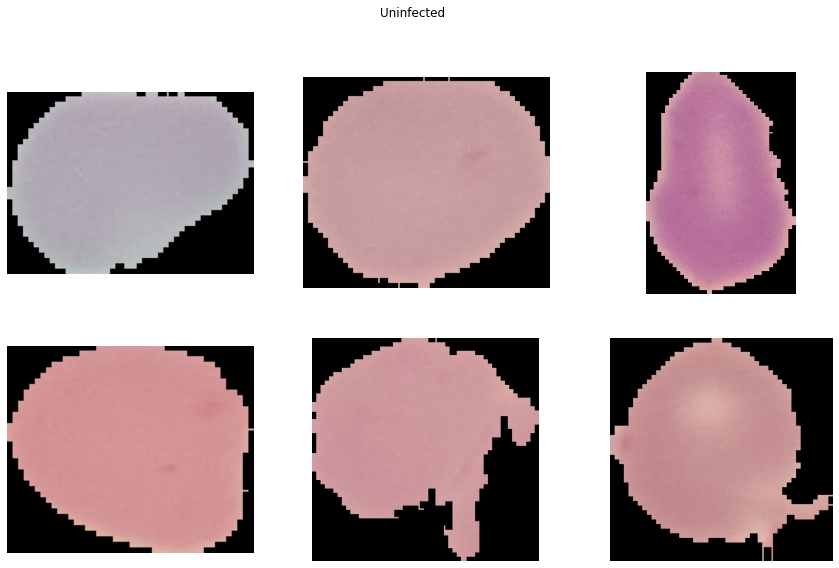

In [18]:
sample_normal = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    # im = cv2.imread('/Users/rutujajadhav/Desktop/r/Dataset/Train/Uninfected/'+sample_normal[i])
    im = cv2.imread('/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Uninfected/'+sample_normal[i])
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    ax[i//3,i%3].imshow(im_rgb)
    ax[i//3,i%3].axis('off')
f.suptitle('Uninfected')
plt.show()

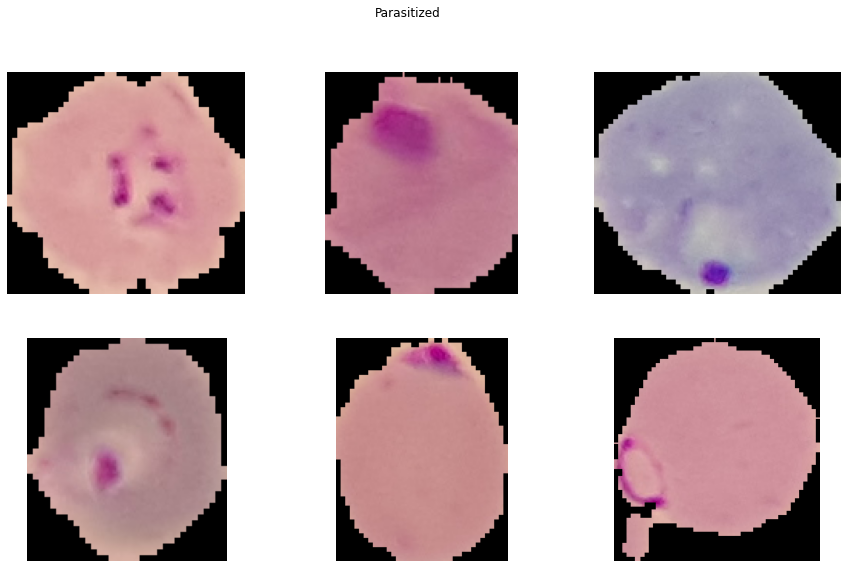

In [60]:
sample_parasite = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    # im = cv2.imread('/Users/rutujajadhav/Desktop/r/Dataset/Train/Parasite/'+sample_parasite[i])
    im = cv2.imread('/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Parasite/'+sample_parasite[i])
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    ax[i//3,i%3].imshow(im_rgb)
    ax[i//3,i%3].axis('off')
f.suptitle('Parasitized')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                  validation_split=0.2) # set validation split

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset/Train/',
                                                 target_size = (227, 227),
                                                 batch_size = 20,
                                                 class_mode = 'categorical',
                                                     subset='training') # set as training data

Found 22058 images belonging to 2 classes.


In [ ]:
validation_data = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset/Train/',
                                                 target_size = (227, 227),
                                                 batch_size = 20,
                                                 class_mode = 'categorical',
                                                     subset='validation') # set as validation data

Found 5513 images belonging to 2 classes.


In [ ]:
test_set1 = test_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset/Test/',
                                            target_size = (227, 227),
                                            batch_size = 20,
                                            class_mode = 'categorical',
                                             shuffle=False)

Found 416 images belonging to 2 classes.


In [ ]:
print('Training Data : '+str(training_set.__len__()))
print('Validation Data : '+str(validation_data.__len__()))

print('Test Data : '+str(test_set1.__len__()))


Training Data : 1103
Validation Data : 276
Test Data : 21


In [ ]:
from tensorflow.keras.models import load_model

r1 = model1.fit(
  training_set,
  validation_data=validation_data,
  epochs=40,
  batch_size = 20,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_data),
  workers=20
)

model1.save('/content/drive/MyDrive/Malaria-Detection/model3_CNN.h5')

import pickle
pickle.dump(model1, open('/content/drive/MyDrive/Malaria-Detection/model3_CNN.pkl', 'wb'))

Epoch 1/40
1103/1103 [==============================] - 837s 740ms/step - loss: 0.5437 - accuracy: 0.7371 - val_loss: 0.2487 - val_accuracy: 0.8913
Epoch 2/40
1103/1103 [==============================] - 649s 586ms/step - loss: 0.2178 - accuracy: 0.9237 - val_loss: 0.2194 - val_accuracy: 0.9332
Epoch 3/40
1103/1103 [==============================] - 645s 583ms/step - loss: 0.1827 - accuracy: 0.9392 - val_loss: 0.2051 - val_accuracy: 0.9240
Epoch 4/40
1103/1103 [==============================] - 646s 584ms/step - loss: 0.1687 - accuracy: 0.9459 - val_loss: 0.1776 - val_accuracy: 0.9376
Epoch 5/40
1103/1103 [==============================] - 652s 587ms/step - loss: 0.1571 - accuracy: 0.9504 - val_loss: 0.1901 - val_accuracy: 0.9378
Epoch 6/40
1103/1103 [==============================] - 659s 595ms/step - loss: 0.1479 - accuracy: 0.9529 - val_loss: 0.1588 - val_accuracy: 0.9436
Epoch 7/40
1103/1103 [==============================] - 662s 596ms/step - loss: 0.1488 - accuracy: 0.9514 - val_

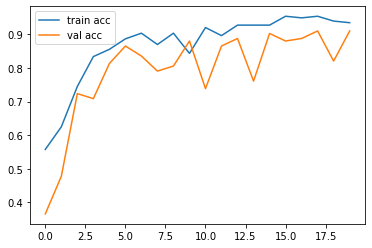

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

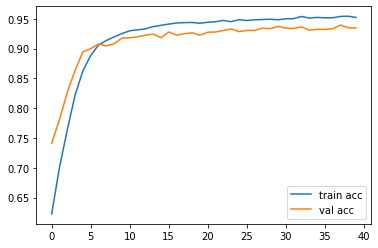

In [ ]:
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save('model2_vgg19.h5')

In [ ]:
print('Training Data : '+str(training_set.__len__()))
print('Test Data : '+str(test_set1.__len__()))


Training Data : 1103
Test Data : 21


In [ ]:
y_pred = model.predict(test_set)

In [ ]:
y_pred

array([[9.9819463e-01, 1.8054114e-03],
       [9.9945599e-01, 5.4407300e-04],
       [9.9471539e-01, 5.2845511e-03],
       [5.5716217e-01, 4.4283780e-01],
       [1.7551520e-01, 8.2448477e-01],
       [1.8165258e-01, 8.1834745e-01],
       [2.5615332e-01, 7.4384671e-01],
       [4.9283889e-01, 5.0716102e-01],
       [2.9270124e-01, 7.0729876e-01],
       [4.6315503e-01, 5.3684497e-01],
       [9.9640012e-01, 3.5998535e-03],
       [1.5682185e-01, 8.4317815e-01],
       [2.6788801e-01, 7.3211199e-01],
       [8.3348185e-01, 1.6651815e-01],
       [9.0849304e-01, 9.1506958e-02],
       [9.9952936e-01, 4.7067297e-04],
       [9.4206548e-01, 5.7934463e-02],
       [9.2250752e-01, 7.7492490e-02],
       [9.9807358e-01, 1.9263531e-03],
       [9.0530747e-01, 9.4692580e-02],
       [9.9999511e-01, 4.8848628e-06],
       [7.7909660e-01, 2.2090338e-01],
       [9.5817727e-01, 4.1822754e-02],
       [4.7147498e-01, 5.2852499e-01],
       [6.4079052e-01, 3.5920948e-01],
       [4.2662790e-01, 5.

In [ ]:
from tensorflow.keras.models import load_model
classifier =load_model('/content/drive/MyDrive/Malaria-Detection/model3_CNN.h5')

In [ ]:
y_pred = classifier.predict(test_set1)

In [ ]:
y_pred1=np.argmax(y_pred, axis=1)

In [ ]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
valid_generator.reset() # resetting generator
y_pred = model.predict_generator(valid_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(valid_generator.classes, y_p

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

print(confusion_matrix(test_set1.classes, y_pred1))


[[206  14]
 [  1 195]]


In [ ]:
print(classification_report(test_set1.classes, y_pred1))


              precision    recall  f1-score   support

           0       1.00      0.94      0.96       220
           1       0.93      0.99      0.96       196

    accuracy                           0.96       416
   macro avg       0.96      0.97      0.96       416
weighted avg       0.97      0.96      0.96       416



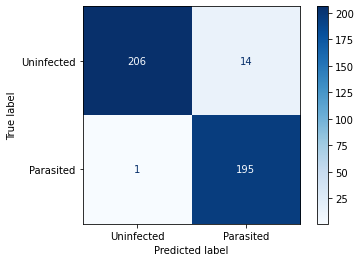

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
labels = ["Uninfected", "Parasited"]
cm = confusion_matrix(test_set1.classes, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [ ]:
classifier.evaluate(test_set1)


21/21 [==============================] - 2s 67ms/step - loss: 0.1042 - accuracy: 0.9639


[0.10421767830848694, 0.963942289352417]

In [ ]:
from tensorflow.keras.models import load_model
classifier1 =load_model('/content/drive/MyDrive/Malaria-Detection/model2_CNN.h5')
def predict_output(img):
  x=image.img_to_array(img)
  x=x/255
  a=np.argmax(classifier1.predict(img_data), axis=1)
  if(a==1):
    return "Uninfected"
  else:
    return "Infected"

In [ ]:
img=image.load_img('/content/drive/MyDrive/Malaria-Detection/TestImages/C99P60ThinF_IMG_20150918_142128_cell_47.png',target_size=(227,227))

In [ ]:
TestImages = os.listdir('/content/drive/MyDrive/Malaria-Detection/TestImages')


In [ ]:
TestImages

['C99P60ThinF_IMG_20150918_142128_cell_110.png',
 'C99P60ThinF_IMG_20150918_142128_cell_104.png',
 'C99P60ThinF_IMG_20150918_142128_cell_80.png',
 'C99P60ThinF_IMG_20150918_142128_cell_55.png',
 'C99P60ThinF_IMG_20150918_142128_cell_47.png',
 'C99P60ThinF_IMG_20150918_141520_cell_17.png',
 'C39P4thinF_original_IMG_20150622_105335_cell_15.png',
 '2.png',
 '.ipynb_checkpoints',
 'Copy of C1_thinF_IMG_20150604_104722_cell_216.png',
 'C241NThinF_IMG_20151207_124643_cell_96.png',
 'C241NThinF_IMG_20151207_124608_cell_22.png',
 'C241NThinF_IMG_20151207_124608_cell_104.png',
 'C241NThinF_IMG_20151207_124643_cell_45.png',
 'C241NThinF_IMG_20151207_124643_cell_136.png',
 'C241NThinF_IMG_20151207_124643_cell_26.png',
 'C241NThinF_IMG_20151207_124608_cell_30.png',
 'C241NThinF_IMG_20151207_124358_cell_149.png',
 'C241NThinF_IMG_20151207_124608_cell_40.png',
 'C241NThinF_IMG_20151207_124608_cell_61.png',
 'C241NThinF_IMG_20151207_124608_cell_51.png',
 'C241NThinF_IMG_20151207_124608_cell_90.png',


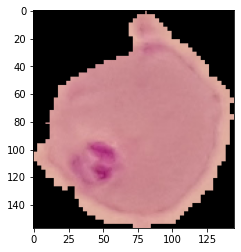

Infected




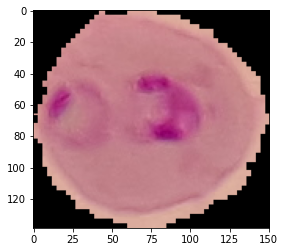

Infected




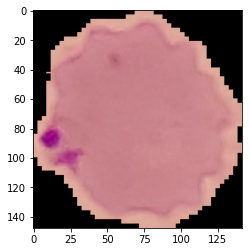

Infected




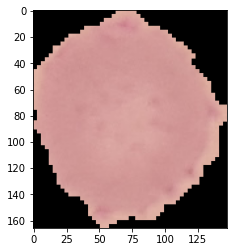

Infected




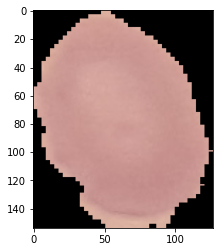

Infected




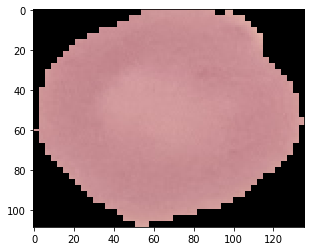

Infected




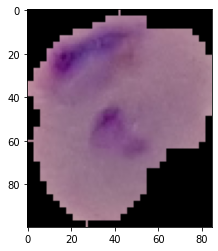

Infected




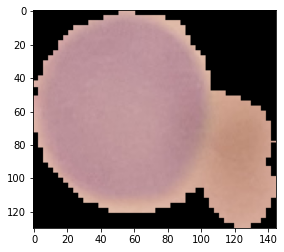

Infected




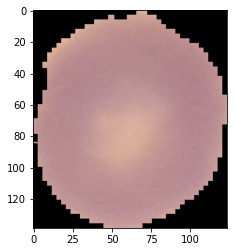

Infected




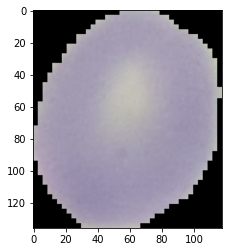

Infected




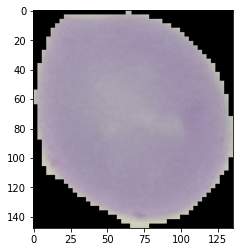

Infected




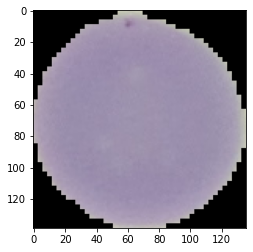

Infected




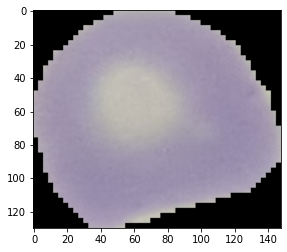

Infected




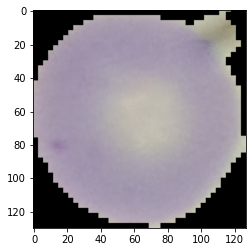

Infected




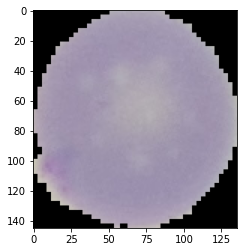

Infected




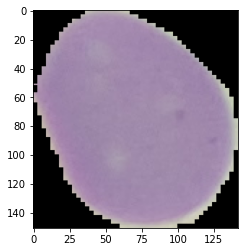

Infected




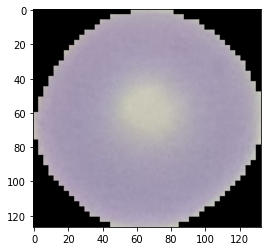

Infected




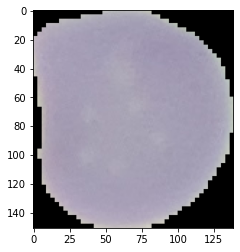

Infected




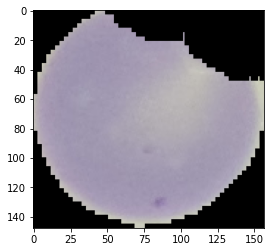

Infected




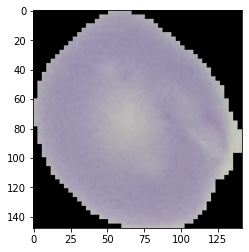

Infected




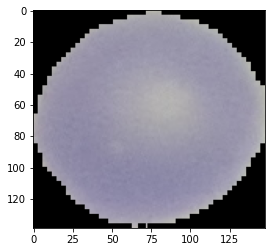

Infected




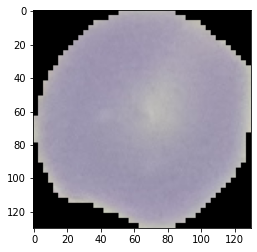

Infected




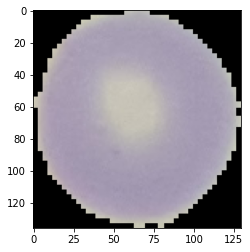

Infected




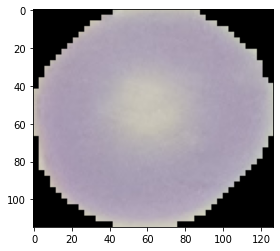

Infected




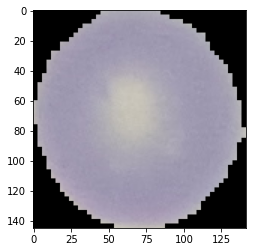

Infected




In [ ]:

for i in range(len(TestImages)):
  if(TestImages[i].endswith('.jpg') or TestImages[i].endswith('.png')):
    img=image.load_img('/content/drive/MyDrive/Malaria-Detection/TestImages/'+TestImages[i],target_size=(227,227))
    im_cv = cv2.imread('/content/drive/MyDrive/Malaria-Detection/TestImages/'+TestImages[i])
    im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)

    plt.imshow(im_rgb)
    plt.show()
    print(predict_output(img))
    print("\n")


In [ ]:
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [ ]:
x.shape

(227, 227, 3)

In [ ]:
x=x/255

In [ ]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 227, 227, 3)

In [ ]:
classifier.predict(img_data)

array([[1., 0.]], dtype=float32)

In [ ]:
a=np.argmax(classifier.predict(x), axis=1)
a

array([0])

In [ ]:
if(a==1):
    print("Uninfected")
else:
    print("Infected")
  

Infected
